In [21]:
import pandas as pd
import numpy as np
import seaborn as sns                       #visualisation
import matplotlib.pyplot as plt             #visualisation
import os 
import wfdb
from collections import defaultdict

## Read Sami Trop Data 

In [2]:
df = pd.read_csv("../data/Sami-Trop.csv")
df.head(10)

exam_id  age  is_male  normal_ecg  death     timey  nn_predicted_age
0   294669   67     True       False  False  2.116020         51.093110
1   291318   65     True       False  False  3.077345         76.923935
2   247007   67    False       False  False  2.378450         61.212074
3   181629   34    False       False  False  2.676793         56.736490
4   250434   52    False       False  False  2.118782         71.822754
5   253698   67    False       False  False  2.071821         74.282010
6   253958   76    False        True  False  2.071821         87.866250
7   406936   75    False       False  False  2.080108         83.031970
8   250492   69    False       False  False  2.080108         54.031060
9   253803   53    False        True  False  2.071821         58.985962

#### Check Types 

In [3]:
df.dtypes

exam_id               int64
age                   int64
is_male                bool
normal_ecg             bool
death                  bool
timey               float64
nn_predicted_age    float64
dtype: object

In [4]:
df.shape

(1631, 7)

In [24]:
df.describe()

exam_id          age        timey  nn_predicted_age
count    1631.000000  1631.000000  1631.000000       1631.000000
mean   377772.297364    59.397302     2.085057         62.617129
std    196466.395984    12.791258     0.392061         14.122801
min      3629.000000    26.000000     0.074586         22.551071
25%    237909.500000    50.000000     1.975136         52.362589
50%    353382.000000    59.000000     2.074583         64.534460
75%    524335.000000    69.000000     2.226517         73.415580
max    873765.000000    98.000000     3.386737         95.928856

In [5]:
## check for duplicate rows 

duplicate_rows = df[df.duplicated()]
print("Duplicate Shape:", duplicate_rows.shape)

## looks like no duplicate rows 

Duplicate Shape: (0, 7)


In [6]:
## lets get the count and check for missing columns 

df.count()
## all here 

exam_id             1631
age                 1631
is_male             1631
normal_ecg          1631
death               1631
timey               1631
nn_predicted_age    1631
dtype: int64

### Creating simple graphs 

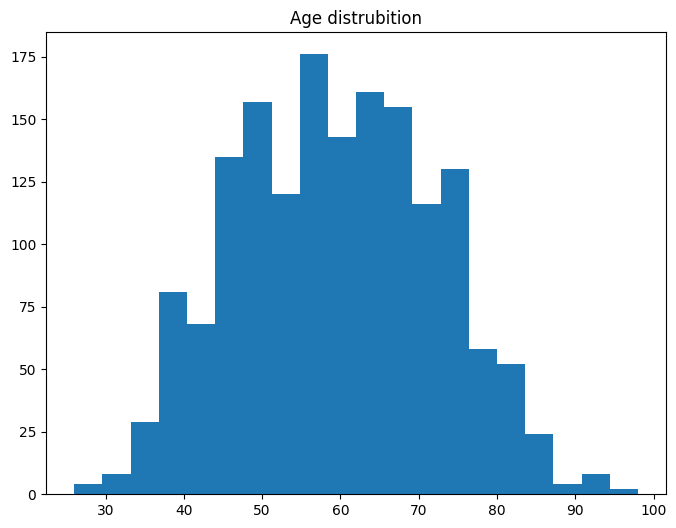

In [7]:
plt.figure(figsize=(8, 6))
plt.hist(df["age"], bins=20)
plt.title("Age distrubition")
plt.show()

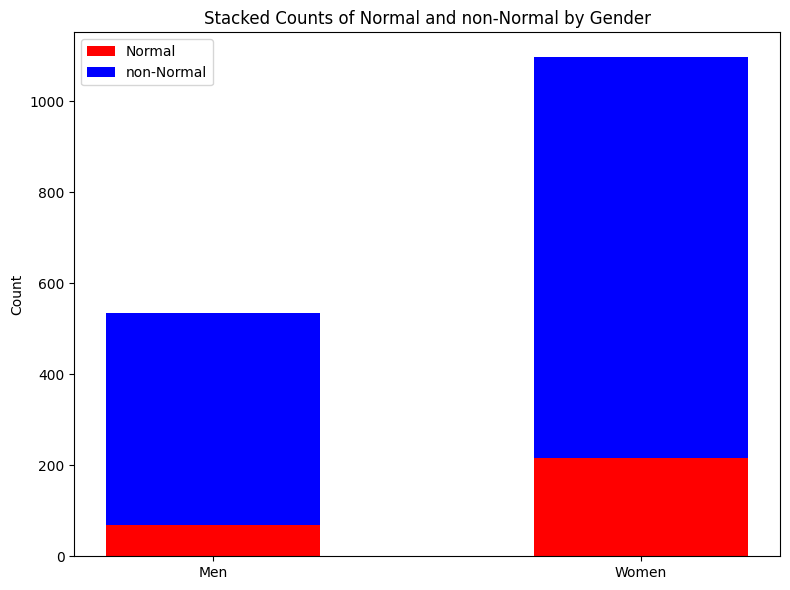

In [8]:
## Men v Woman 

x = np.arange(len(df["is_male"]))
bar_width = 0.5 

grouped = df.groupby(['is_male', 'normal_ecg']).size().unstack(fill_value=0)
for val in [True, False]:
    if val not in grouped.columns:
        grouped[val] = 0

# Prepare data
men_positive = grouped.loc[True, True] if True in grouped.index else 0
men_negative = grouped.loc[True, False] if True in grouped.index else 0
women_positive = grouped.loc[False, True] if False in grouped.index else 0
women_negative = grouped.loc[False, False] if False in grouped.index else 0

labels = ['Men', 'Women']
positives = [men_positive, women_positive]
negatives = [men_negative, women_negative]

x = range(len(labels))
bar_width = 0.5

# Plotting
fig, ax = plt.subplots(figsize=(8, 6))

ax.bar(x, positives, bar_width, label='Normal', color='red')
ax.bar(x, negatives, bar_width, bottom=positives, label='non-Normal', color='blue')

# Labeling
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylabel('Count')
ax.set_title('Stacked Counts of Normal and non-Normal by Gender')
ax.legend()

plt.tight_layout()
plt.show()

In [9]:
positive_df = df[df['normal_ecg'] == True]
positive_df.shape

(286, 7)

## Lets Read the HDF5 file  

In [25]:
# Path to the files
folder_path = r'..\data\wfdb_output'

# Get record names from .hea files
record_names = [f[:-4] for f in os.listdir(folder_path) if f.endswith('.hea')]

# Store all samples by channel name
channel_data = defaultdict(list)

# Aggregate signal data
for record_name in record_names:
    record_path = os.path.join(folder_path, record_name)

    try:
        record = wfdb.rdrecord(record_path)
        for i, channel in enumerate(record.sig_name):
            signal = record.p_signal[:, i]
            channel_data[channel].append(signal)
    except Exception as e:
        print(f"❌ Failed to read {record_name}: {e}")

# Flatten and compute stats per channel
summary_stats = []

for channel, signals in channel_data.items():
    all_data = np.concatenate(signals)  # Flatten across records

    stats = {
        'Channel': channel,
        'Mean': np.mean(all_data),
        'Std': np.std(all_data),
        'Min': np.min(all_data),
        'Max': np.max(all_data),
        'RMS': np.sqrt(np.mean(all_data**2)),
        'Total Samples': len(all_data)
    }

    summary_stats.append(stats)

# Convert to DataFrame for clean display
summary_df = pd.DataFrame(summary_stats)
print(summary_df)

   Channel      Mean       Std        Min        Max       RMS  Total Samples
0       DI  0.021518  1.166289 -20.790279  30.172278  1.166488        5735382
1      DII  0.204060  1.928850 -17.118015  17.397689  1.939614        5735382
2     DIII  0.182550  1.871344 -29.935640  20.678986  1.880227        5735382
3      AVR -0.111339  1.290861 -22.530193  13.766040  1.295653        5735382
4      AVL -0.079898  1.225540 -20.732691  29.864093  1.228141        5735382
5      AVF  0.193968  1.807582 -17.152102  14.030872  1.817960        5735382
6       V1 -0.377349  1.500228 -30.169912  21.851815  1.546957        5735382
7       V2 -0.452233  1.473283 -19.912212  24.905546  1.541128        5735382
8       V3 -0.462703  1.685000 -23.081823  24.229706  1.747375        5735382
9       V4 -0.519411  1.705023 -19.640059  16.544215  1.782384        5735382
10      V5 -0.613558  1.881933 -22.129116  29.916682  1.979426        5735382
11      V6 -0.911704  2.233291 -19.253120  21.128420  2.412217  

..\data\wfdb_output\record_0000

✅ Loaded: record_0000
  - Sampling frequency: 400
  - Signal shape: (4096, 12)
  - Channel names: ['DI', 'DII', 'DIII', 'AVR', 'AVL', 'AVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']


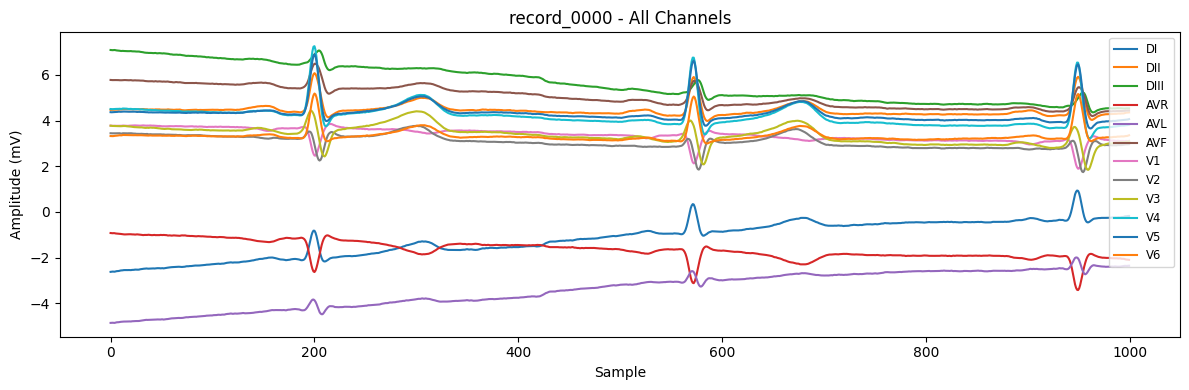

..\data\wfdb_output\record_0001

✅ Loaded: record_0001
  - Sampling frequency: 400
  - Signal shape: (4096, 12)
  - Channel names: ['DI', 'DII', 'DIII', 'AVR', 'AVL', 'AVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']


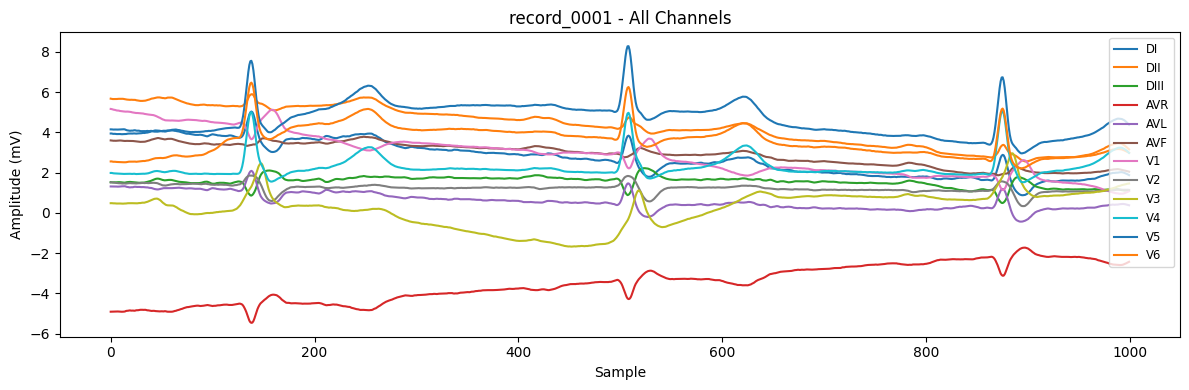

..\data\wfdb_output\record_0002

✅ Loaded: record_0002
  - Sampling frequency: 400
  - Signal shape: (4096, 12)
  - Channel names: ['DI', 'DII', 'DIII', 'AVR', 'AVL', 'AVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']


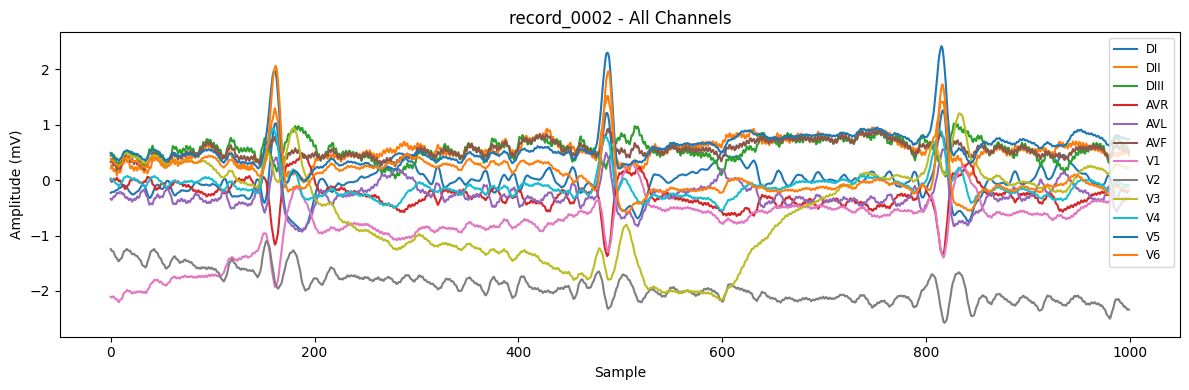

..\data\wfdb_output\record_0003

✅ Loaded: record_0003
  - Sampling frequency: 400
  - Signal shape: (2934, 12)
  - Channel names: ['DI', 'DII', 'DIII', 'AVR', 'AVL', 'AVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']


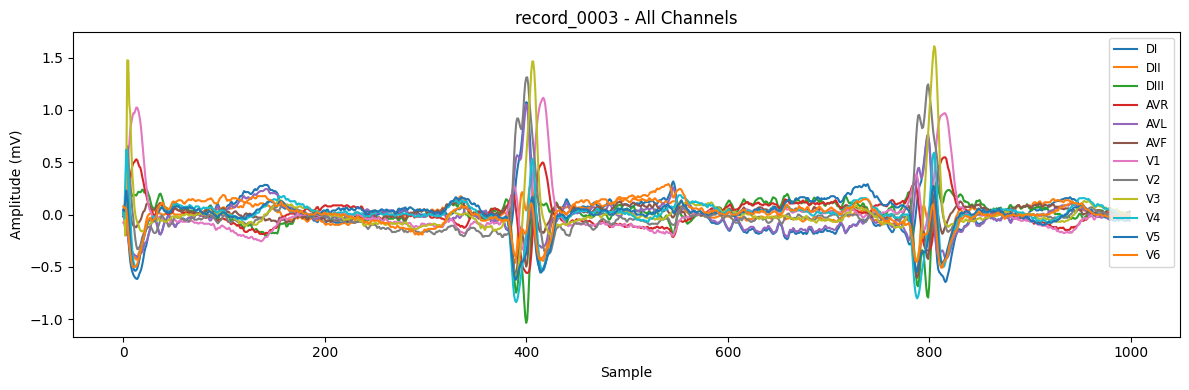

..\data\wfdb_output\record_0004

✅ Loaded: record_0004
  - Sampling frequency: 400
  - Signal shape: (4096, 12)
  - Channel names: ['DI', 'DII', 'DIII', 'AVR', 'AVL', 'AVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']


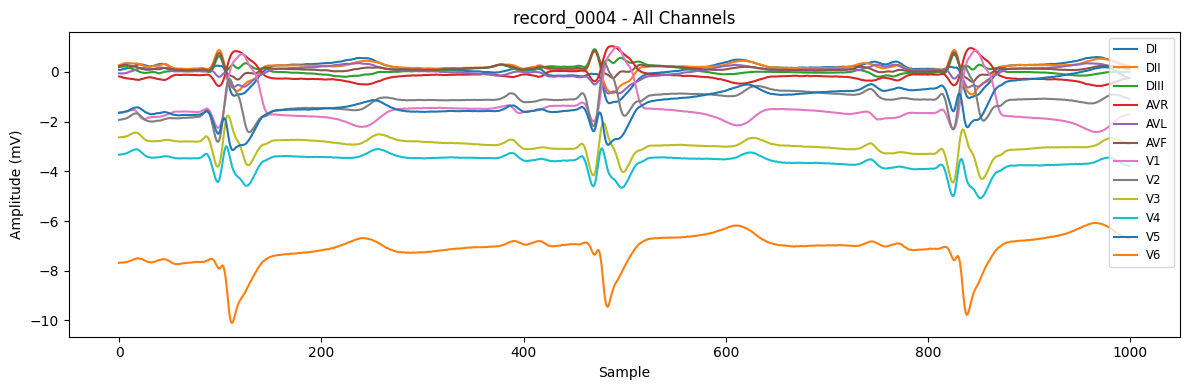

..\data\wfdb_output\record_0005

✅ Loaded: record_0005
  - Sampling frequency: 400
  - Signal shape: (4096, 12)
  - Channel names: ['DI', 'DII', 'DIII', 'AVR', 'AVL', 'AVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']


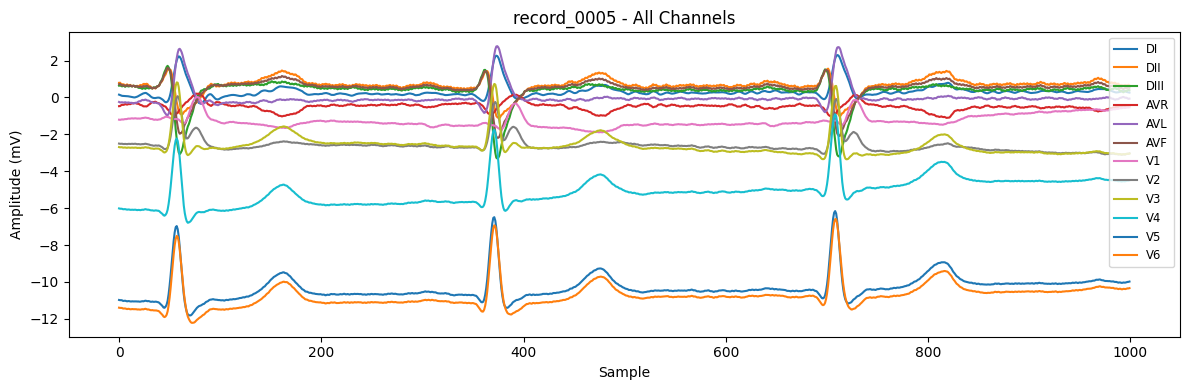

..\data\wfdb_output\record_0006

✅ Loaded: record_0006
  - Sampling frequency: 400
  - Signal shape: (4096, 12)
  - Channel names: ['DI', 'DII', 'DIII', 'AVR', 'AVL', 'AVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']


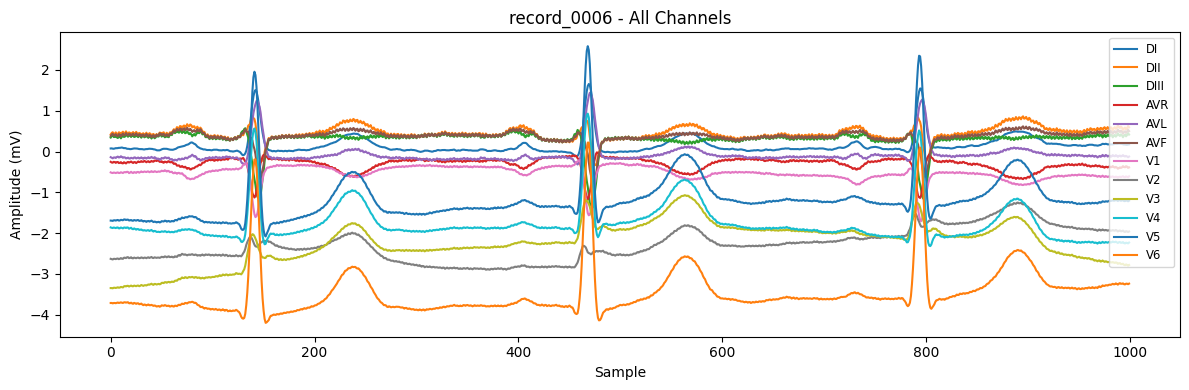

..\data\wfdb_output\record_0007

✅ Loaded: record_0007
  - Sampling frequency: 400
  - Signal shape: (2934, 12)
  - Channel names: ['DI', 'DII', 'DIII', 'AVR', 'AVL', 'AVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']


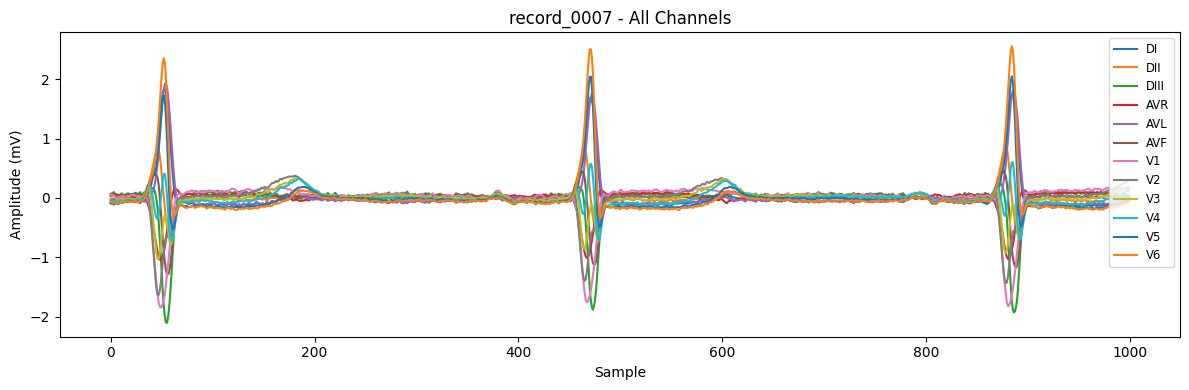

..\data\wfdb_output\record_0008

✅ Loaded: record_0008
  - Sampling frequency: 400
  - Signal shape: (4096, 12)
  - Channel names: ['DI', 'DII', 'DIII', 'AVR', 'AVL', 'AVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']


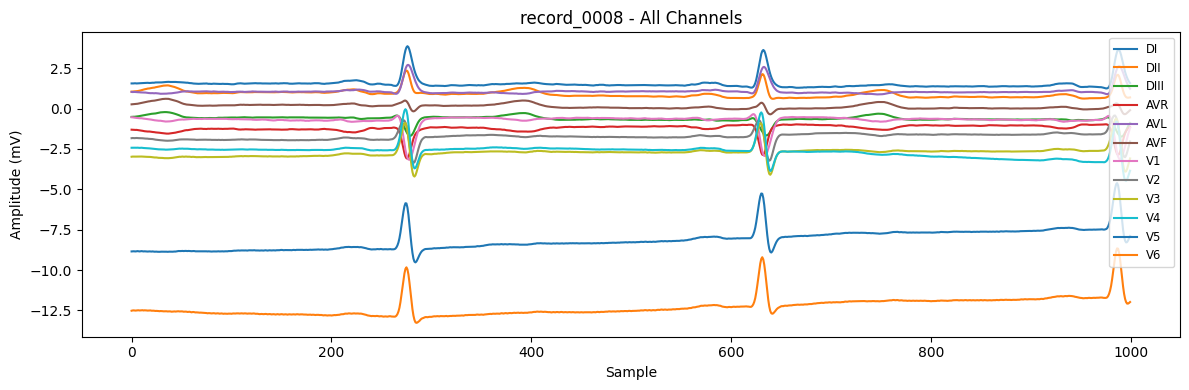

..\data\wfdb_output\record_0009

✅ Loaded: record_0009
  - Sampling frequency: 400
  - Signal shape: (4096, 12)
  - Channel names: ['DI', 'DII', 'DIII', 'AVR', 'AVL', 'AVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']


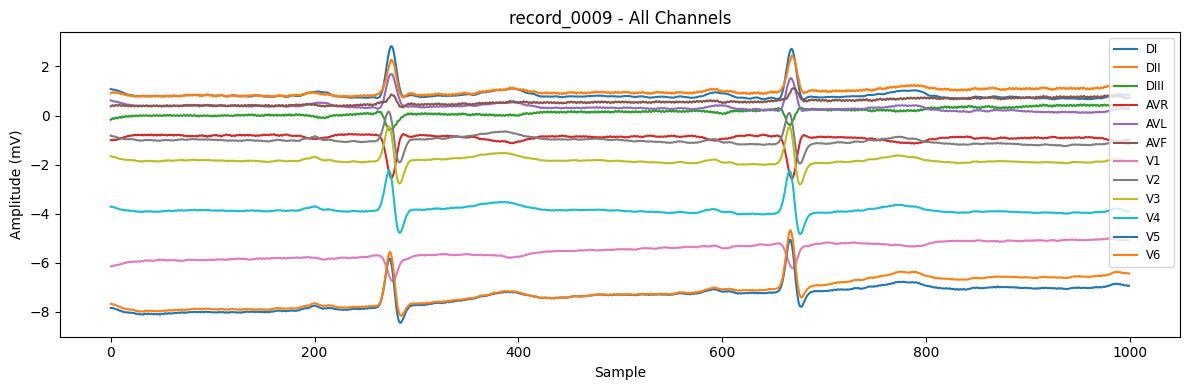

..\data\wfdb_output\record_0010

✅ Loaded: record_0010
  - Sampling frequency: 400
  - Signal shape: (4096, 12)
  - Channel names: ['DI', 'DII', 'DIII', 'AVR', 'AVL', 'AVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']


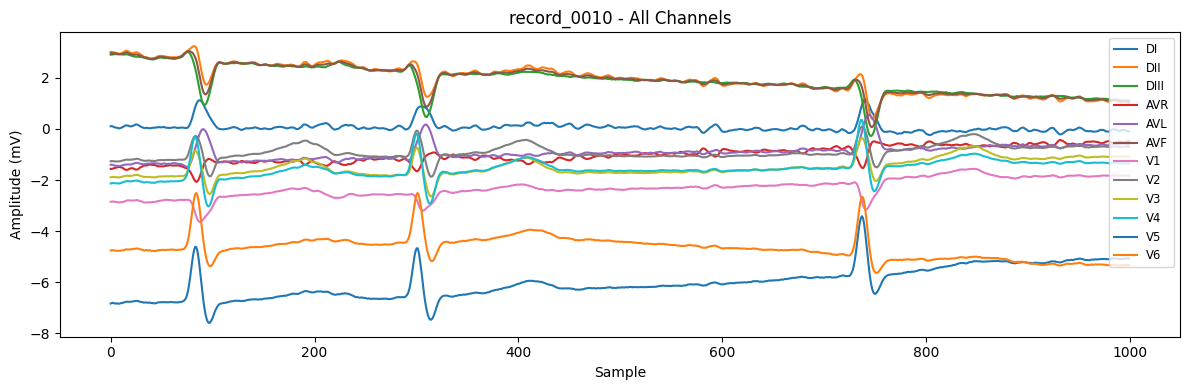

..\data\wfdb_output\record_0011

✅ Loaded: record_0011
  - Sampling frequency: 400
  - Signal shape: (4096, 12)
  - Channel names: ['DI', 'DII', 'DIII', 'AVR', 'AVL', 'AVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']


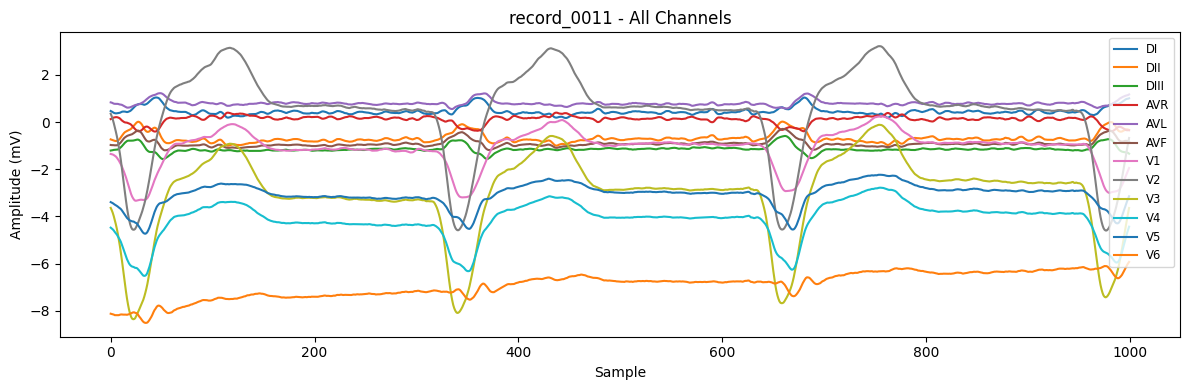

In [19]:

# path to the files 
folder_path = '..\data\wfdb_output'

# Get all .hea files to extract the record names
record_names = [f[:-4] for f in os.listdir(folder_path) if f.endswith('.hea')]

limit = 10 
# Loop over each record
for record_name in record_names:
    record_path = os.path.join(folder_path, record_name)

    try:
        # Read the record
        print(record_path)
        record = wfdb.rdrecord(record_path)

        print(f"\n✅ Loaded: {record_name}")
        print(f"  - Sampling frequency: {record.fs}")
        print(f"  - Signal shape: {record.p_signal.shape}")
        print(f"  - Channel names: {record.sig_name}")

        # Plot all channels on a single graph (first 1000 samples)
        plt.figure(figsize=(12, 4))
        for i in range(record.p_signal.shape[1]):
            plt.plot(record.p_signal[:1000, i], label=record.sig_name[i])
        
        plt.title(f'{record_name} - All Channels')
        plt.xlabel('Sample')
        plt.ylabel('Amplitude (mV)')
        plt.legend(loc='upper right', fontsize='small')
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"❌ Failed to read {record_name}: {e}")
    if limit < 0:
        break
    limit -= 1 

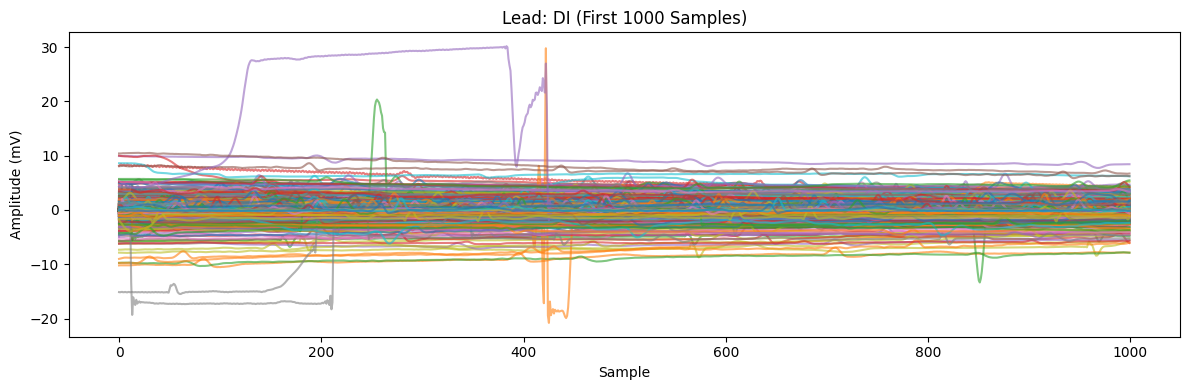

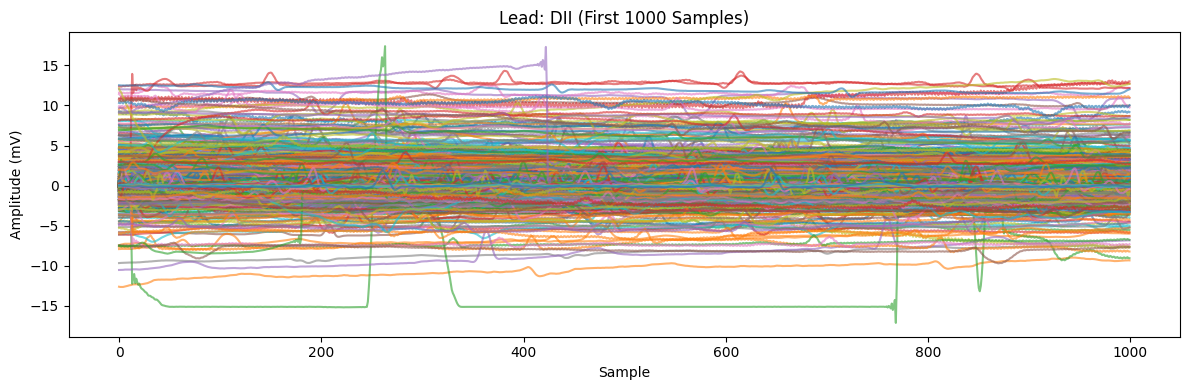

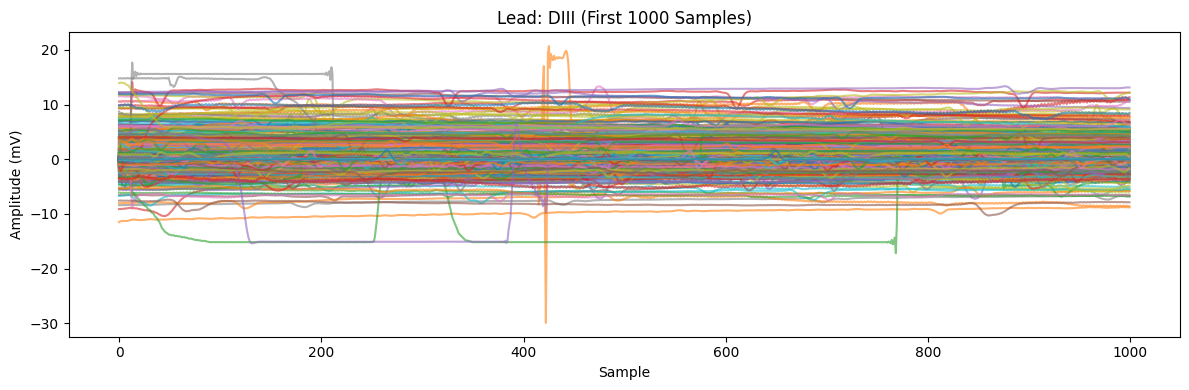

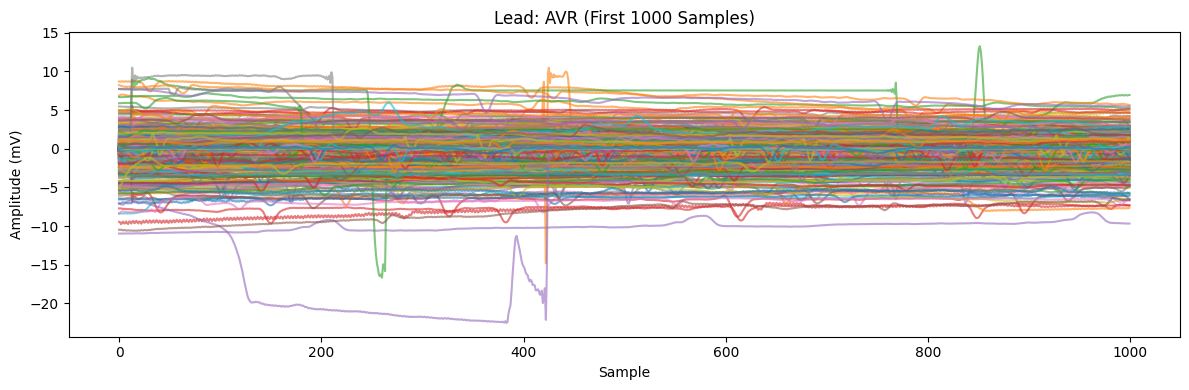

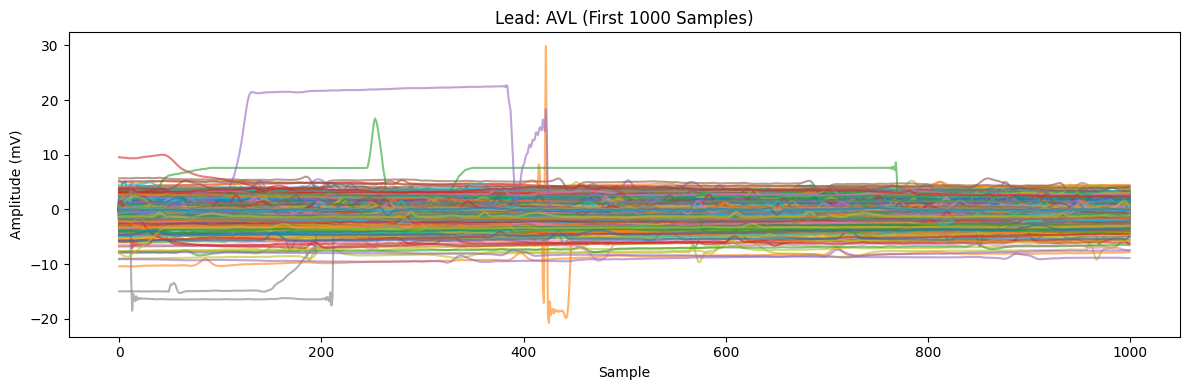

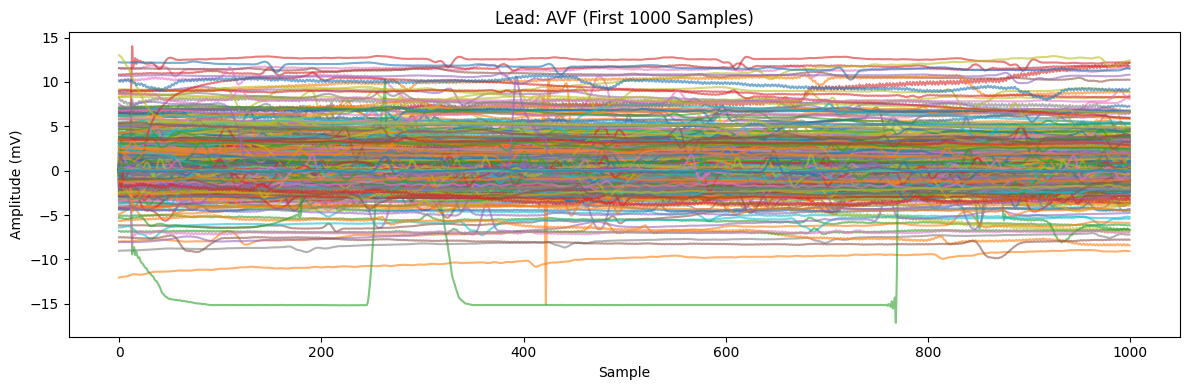

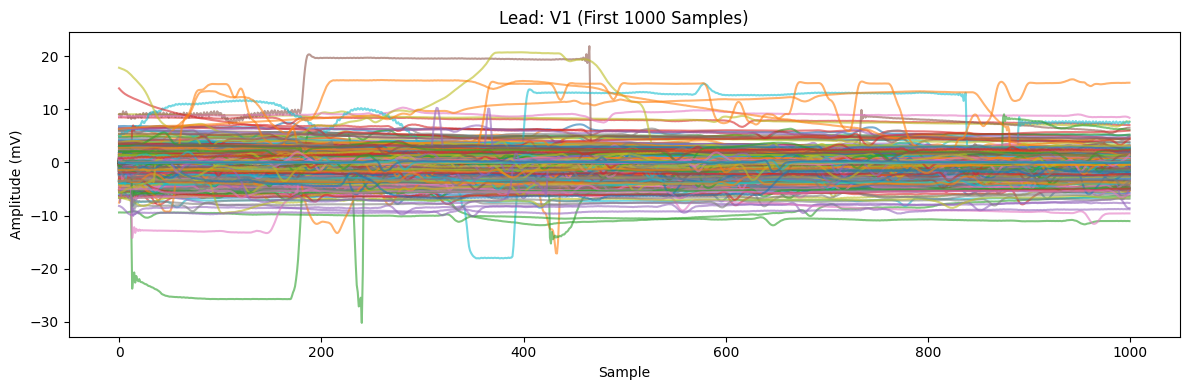

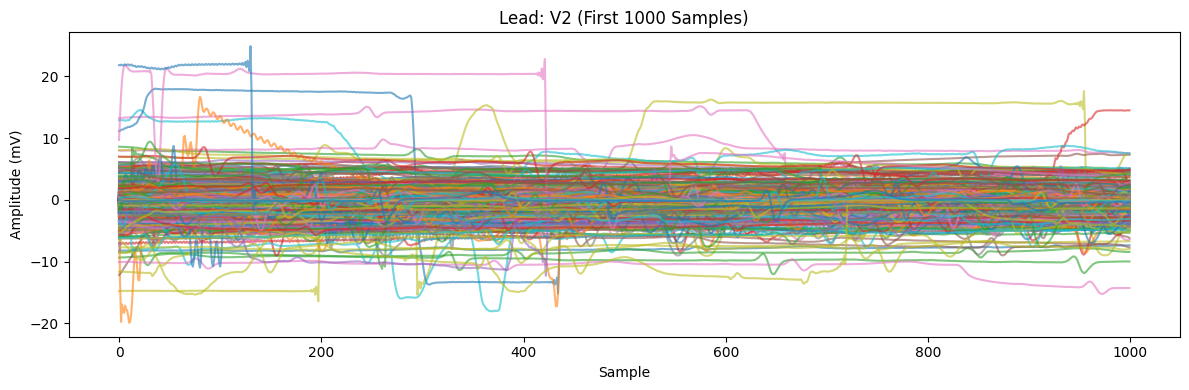

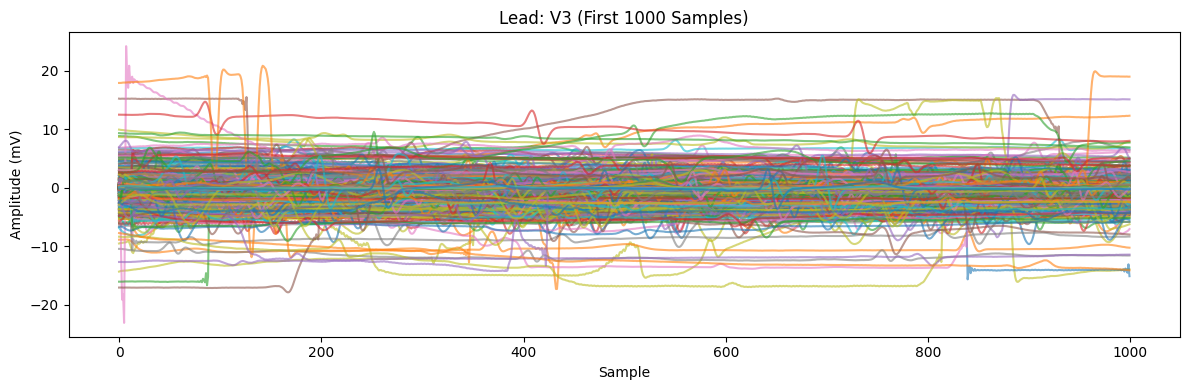

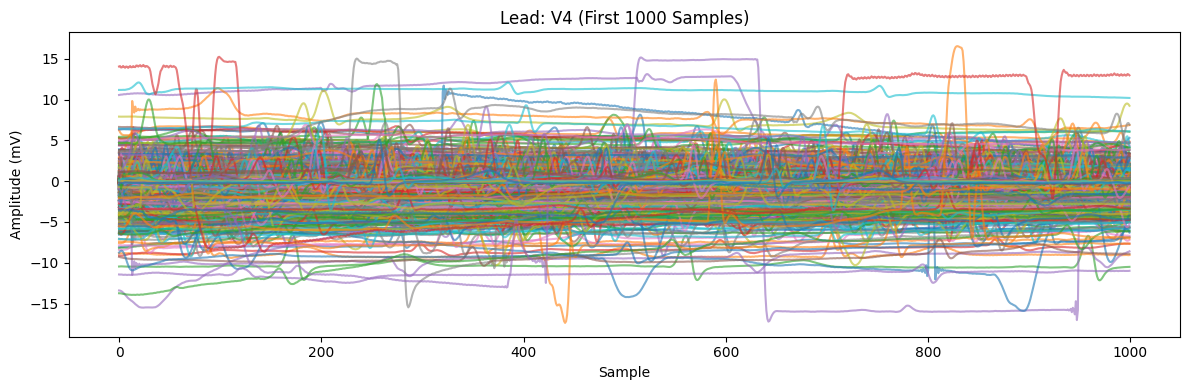

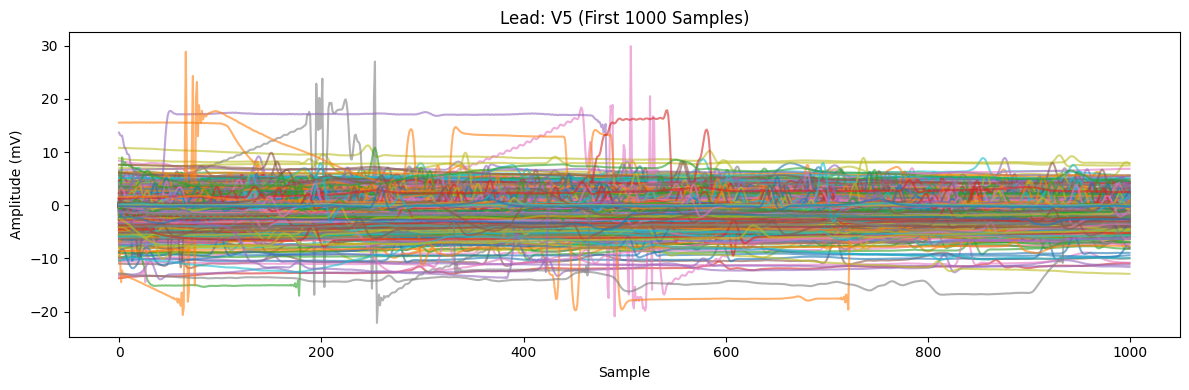

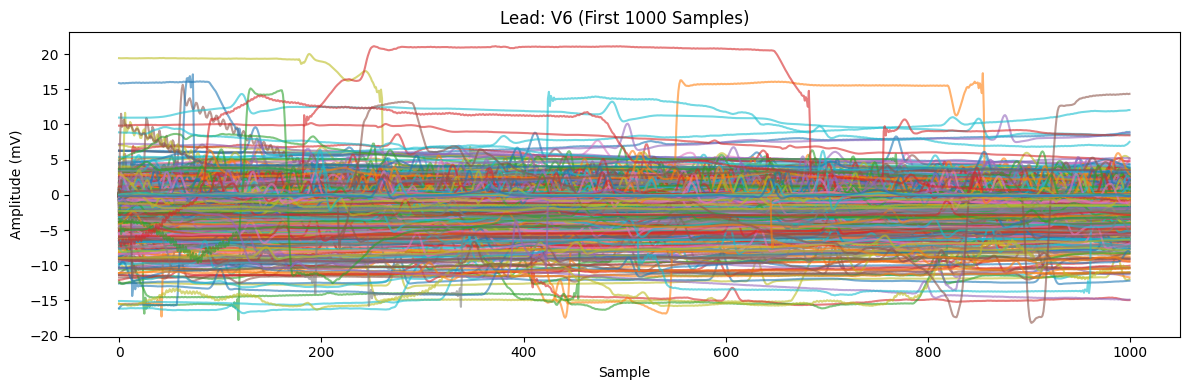

In [23]:
# Path to the files
folder_path = r'..\data\wfdb_output'

# Get all .hea files to extract the record names
record_names = [f[:-4] for f in os.listdir(folder_path) if f.endswith('.hea')]

# Dictionary to hold signals for each lead
lead_signals = defaultdict(list)

# Collect signals
for record_name in record_names:
    record_path = os.path.join(folder_path, record_name)

    try:
        record = wfdb.rdrecord(record_path)
        sig = record.p_signal  # shape: (samples, channels)

        for i, lead_name in enumerate(record.sig_name):
            # Save first 1000 samples of this lead
            lead_signals[lead_name].append(sig[:1000, i])

    except Exception as e:
        print(f"❌ Failed to read {record_name}: {e}")

# Plot all records for each lead on separate graphs
for lead_name, signals in lead_signals.items():
    plt.figure(figsize=(12, 4))
    
    for i, signal in enumerate(signals):
        plt.plot(signal, label=f'Record {i+1}', alpha=0.6)

    plt.title(f'Lead: {lead_name} (First 1000 Samples)')
    plt.xlabel('Sample')
    plt.ylabel('Amplitude (mV)')
    plt.tight_layout()
    plt.show()